# Random Forest

## Voting classifier

Assume that we have several trained classifiers. The easiest way to make a better classifer out of what we already have is to build a voting system. That is, each classifier give its own prediction, and it will be considered as a vote, and finally the highest vote will be the prediction of the system. 


## Basic bagging
One approach to get many estimators is to use the same training algorithm for every predictor and train them on different random subsets of the training set. When sampling is performed with replacement, this method is called *bagging* (short for *bootstrap aggregating*). When sampling is performed without replacement, it is called *pasting*.

Consider the following example. The dataset is the one we used in Chpater 3: `make_moon`. We split the dataset into training and test sets.

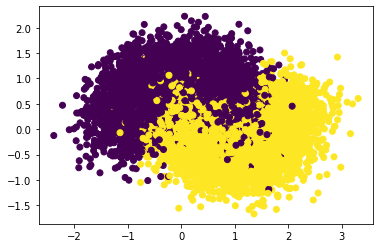

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)
plt.scatter(x=X[:, 0], y=X[:, 1], c=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

We would like to sample from the dataset to get some smaller minisets. We will use `sklearn.model_selection.ShuffleSplit` to perform the action. 

The output of `ShuffleSplit` is a generator. To get the index out of it we need a `for` loop. You may check out the following code. 

Note that `ShuffleSplit` is originally used to shuffle data into training and test sets. We would only use the shuffle function out of it, so we will set `test_size` to be `1` and use `_` later in the `for` loop since we won't use that part of the information.

What we finally get is a list consists of tuples of mini set of `X_train` and `y_train`.

In [2]:
from sklearn.model_selection import ShuffleSplit
n_trees = 1000
n_instances = 100
rs = ShuffleSplit(n_splits=n_trees, test_size=1, train_size=n_instances)
mini_sets = list()
for mini_train_index, _ in rs.split(X_train):
    mini_sets.append((X_train[mini_train_index], y_train[mini_train_index]))

Now we would like to generate a list of Decision Trees. We could use the hyperparameters we get from Chapter 3. We train each tree over a certain mini set, and then evaluate the trained model over the test set. The average accuracy is around 80%.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.metrics import accuracy_score
import numpy as np

tree_list = [clone(DecisionTreeClassifier(min_samples_split=2, max_leaf_nodes=17))
             for _ in range(n_trees)]
acc_list = list()
for i in range(n_trees):
    tree = tree_list[i]
    (X_mini_train, y_mini_train) = mini_sets[i]
    tree.fit(X_mini_train, y_mini_train)

    y_pred = tree.predict(X_test)
    acc_list.append(accuracy_score(y_pred, y_test))
np.mean(acc_list)


0.808516

Now for each test data, we actually have `n_trees=1000` predicted results. We can treat it as the options from 1000 exports and would like to use the majority as our result. For this purpose we would like to use `mode()` which will find the most frequent entry.

In [4]:
from scipy.stats import mode
voting = np.array([tree.predict(X_test) for tree in tree_list])
y_pred_mode, _ = mode(voting, axis=0)


Since the output of `mode` is a tuple where the first entry is a 2D array, we need to reshape `y_pred_mode`. This is the result using this voting system. Then we are able to compute the accuracy, and find that it is increased from the previous prediction.

In [5]:
y_pred_mode = y_pred_mode.reshape(y_pred_mode.size)
accuracy_score(y_pred_mode, y_test)

0.884



## Using `sklearn`

`sklearn` provides `BaggingClassifier` to directly perform bagging or pasting. The code is as follows.

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=1000,
                            max_samples=100,
                            bootstrap=True)

In the above code, `bag_clf` is a bagging classifier, made of 500 `DecisionTreeClassifer`s, and is trained over subsets of size `100`. The option `bootstrap=True` means that it is bagging. If you would like to use pasting, the option is `bootstrap=False`.

This `bag_clf` also has `.fit()` and `.predict()` methods. It is used the same as our previous classifiers. Let us try the `make_moon` dataset.


In [7]:
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
accuracy_score(y_pred_bag, y_test)

0.8826666666666667

## Random Forests
When the classifiers used in a bagging classifier are all Decision Trees, the bagging classifier is called a `random forest`. `sklearn` provide `RandomForestClassifier` class. It is almost the same as `BaggingClassifier` + `DecisionTreeClassifer`.


In [8]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=17)
rnd_clf.fit(X_train, y_train)
y_pred_rnd = rnd_clf.predict(X_test)
accuracy_score(y_pred_rnd, y_test)

0.8826666666666667

When we use the Decision Tree as our base estimators, the class `RandomForestClassifier` provides more control over growing the random forest, with a certain optimizations. If you would like to use other estimators, then `BaggingClassifier` should be used.